1. **Learn a multivariate Gaussian and generate samples**

2. Learn VAE and generate samples

      a. train Model A. VAE with Conv2d, ConvTranspose2d, kernel_size=4, stride=2, latent_dims = 2

      b. train Model B. Find a model that yields the “checkerboard artifacts”

      c. train Model C. VAE with Conv2d, ConvTranspose2d, kernel_size=3, stride=2, latent_dims = 10

      d. compare Model A, B, C

      e. Interpolation in Latent Space

          - Interpolate 0 and 9 in latent space. (Model A)
          - (quiz) run cell multiple times: “Interpolation in Latent Space”, explain why different results are obtained
          
      f. Sample Latent Vector from “Prior” (VAE as Generator) (Model A)

          - Compare the prior and the distribution of training data in the latent space
          - Sample Latent Vector from estimated Gaussian


## Settings

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/package'
save_path = '/content/drive/MyDrive/Colab Notebooks/package' 

os.symlink(save_path, my_path)
sys.path.insert(0, my_path)

In [ ]:
!pip3 install --target=$my_path torch
!pip3 install --target=$my_path torchvision

Density Estimation
======
(Explicit Density Estimation)
* Gaussian

In [ ]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np

use_gpu = True

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We do not center them at 0, because we will be using a binary cross-entropy loss that treats pixel values as probabilities in [0,1]. We create both a training set and a test set.

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])  
# transforms.ToTensor() 
## Image->FloatTensor로 변환  
## 이미지의 픽셀의 크기(intensity)값을 0~1로 scaling

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
batch_size = len(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # 미니 배치 구성 # shuffle : 데이터의 순서를 학습하지 못하게 

# Get first batch = train_dataloader.__iter__().__next__()
for X, y in train_dataloader:
    break;

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

In [ ]:
# batch 확인
first_batch = train_dataloader.__iter__().__next__()

print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(train_dataloader)))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))


name            | type                      | size
Num of Batch    |                           | 1
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([60000, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([60000])


In [ ]:
# For visualization
def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
def to_img(x): # Project pixel values on the unit interval [0,1] 
    x = x.clamp(0, 1) # clamp : 입력으로 들어오는 모든 값을 [min, max]의 범위로 조정
    return x

def imshow_tensor(img, cmap='gray'):
    img = to_img(img)
    if img.get_device() >=0: # if the img tensor is on GPU
        img = img.cpu()

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap=cmap)
    
def imshow_cov_tensor(S, cmap='gray'):
    imshow_tensor(S[None, ...], cmap=cmap)

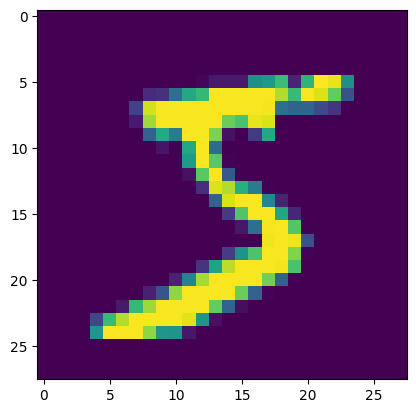

In [ ]:
# Visualization code 
#image, label = train_dataset[0]
#plt.imshow(image.squeeze().numpy(), cmap='gray')
#plt.show()

show_image(train_dataset[0][0])

Compute Mean and Covariance Matrix without iterations 
=========================

In [ ]:
train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
batch_size = len(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
for X, y in train_dataloader:
    break;

torch.Size([60000, 1, 28, 28])


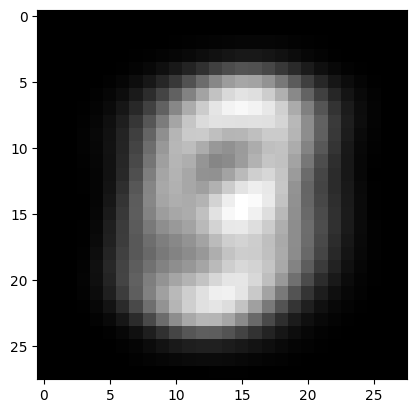

In [ ]:
# Compute Mean of training data
print(X.shape)
mu = torch.mean(X,0) # dim = 0 : compute mean of 60000 training data
imshow_tensor(mu)

In [ ]:
print(X.shape)
print(X.reshape(batch_size,-1).shape)
print(X.reshape(batch_size,-1).transpose(1,0).shape) 

torch.Size([60000, 1, 28, 28])
torch.Size([60000, 784])
torch.Size([784, 60000])


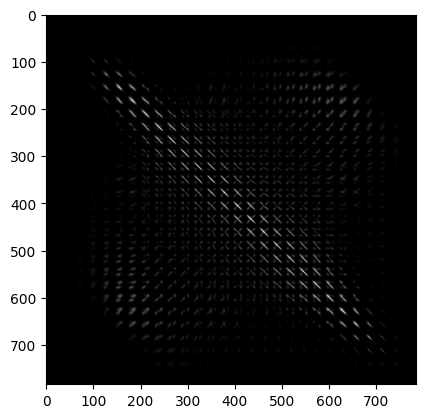

In [ ]:
# Compute covariance matrix of training data
S = torch.cov(X.reshape(batch_size,-1).transpose(1,0))  
# .reshape(,-1) : flatten to 1-dim vector 
# .transpose(a,b) : change 2-dim

imshow_cov_tensor(S)

Generate samples from learned Gaussian
==========================
* $\mu$ is the sample mean 
* $S$ is the sample covariance matrix 
* We use $\tilde{S} + \alpha I$ to have a positive definite covariance matrix, where $\alpha>0$ is small

In [ ]:
# Add small identify to avoid rank-deficient covariance matrix (0 variance... at some pixels)
alpha = 0.0001 
Saug = S+alpha*torch.eye(S.shape[0]) # Augment the Covariance Matrix with alpha = 0.0001

alpha2 = 0.005
Saug2 = S+alpha2*torch.eye(S.shape[0]) # Augment the Covariance Matrix with alpha = 0.005

alpha3 = 0.05
Saug3 = S+alpha3*torch.eye(S.shape[0]) # Augment the Covariance Matrix with alpha = 0.05

mu_vec= mu.view(-1)

mvn_Saug = torch.distributions.multivariate_normal.MultivariateNormal(mu_vec, Saug)
mvn_Saug2 = torch.distributions.multivariate_normal.MultivariateNormal(mu_vec, Saug2)
mvn_Saug3 = torch.distributions.multivariate_normal.MultivariateNormal(mu_vec, Saug3)

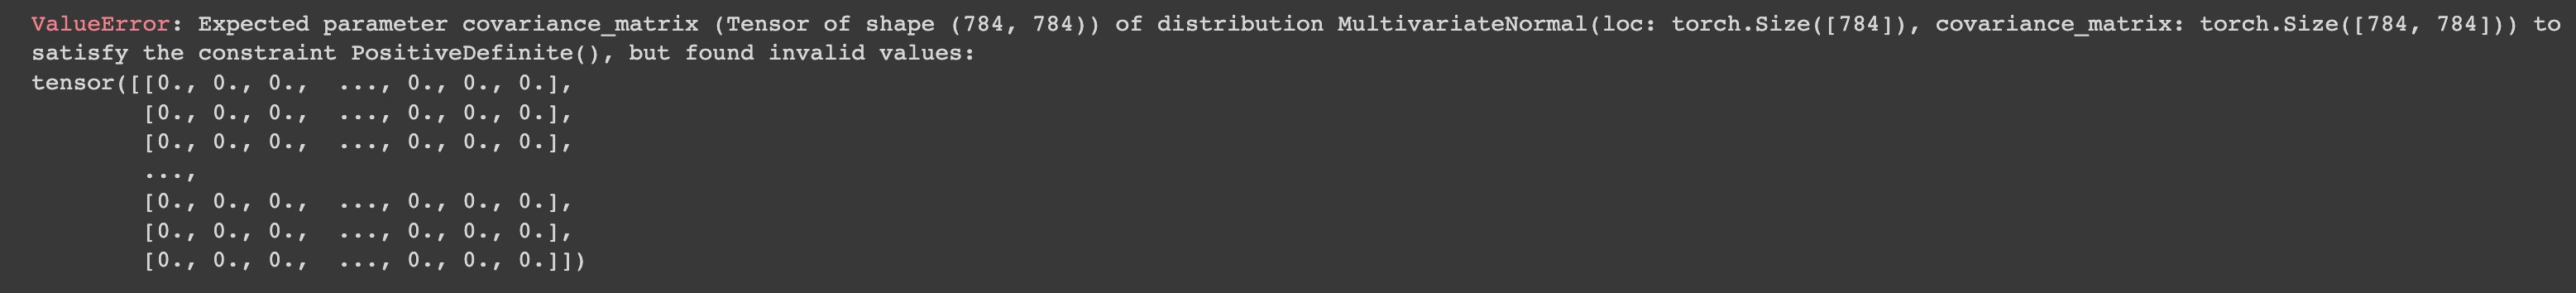

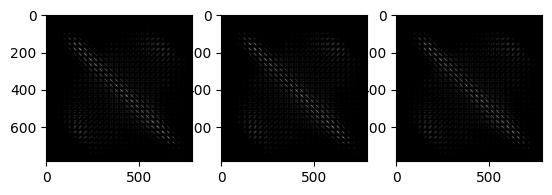

In [ ]:
#imshow_cov_tensor(S), imshow_cov_tensor(Saug)
plt.subplot(131)
imshow_cov_tensor(S)

plt.subplot(132)
imshow_cov_tensor(Saug)

plt.subplot(133)
imshow_cov_tensor(Saug2)

plt.show()

In [ ]:
mvn.sample().shape #각 pixel을 estimate한 pdf로부터 sampling한 결과 (pixel1 ~ pdf1, pixel2 ~ pdf2 , ...) 즉, 최종 sampling 결과물은 784 

torch.Size([784])

In [ ]:
x_gen = mvn.sample().reshape(1,28,-1) #이미지 형태로 reshape

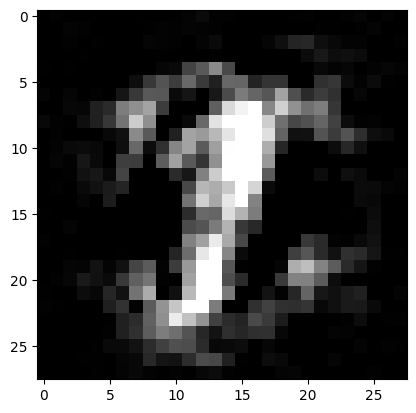

In [ ]:
imshow_tensor(x_gen)

In [ ]:
n_samples = 20
width = 28
height = 28

X_gen1 = torch.zeros(n_samples, width, height)
X_gen2 = torch.zeros(n_samples, width, height)
X_gen3 = torch.zeros(n_samples, width, height)


for i in range(20):
    X_gen1[i] = mvn_Saug.sample().reshape(28,-1)
    X_gen2[i] = mvn_Saug2.sample().reshape(28,-1)
    X_gen3[i] = mvn_Saug3.sample().reshape(28,-1)

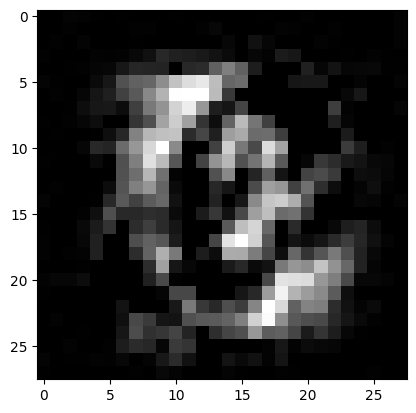

In [ ]:
idx = 0
imshow_tensor(X_gen[None, idx, ...]) # visualize the first image

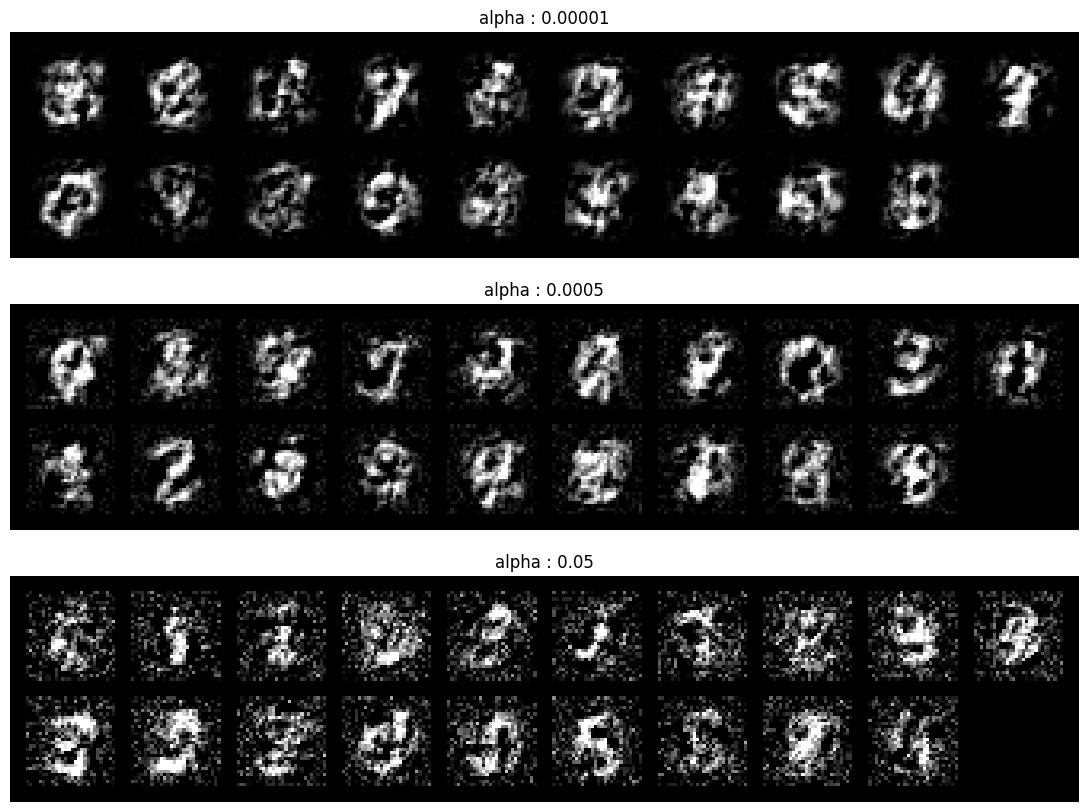

In [ ]:
# Visualize all the generated images
from matplotlib.gridspec import GridSpec 

fig = plt.figure(figsize=(20, 10))
gs = GridSpec(nrows=3, ncols=1)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])

images = X_gen1.cpu()[:,None,...]
images = to_img(images)
np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
ax0.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
ax0.set_title('alpha : 0.00001')
ax0.axis("off")


images = X_gen2.cpu()[:,None,...]
images = to_img(images)
np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
ax1.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
ax1.set_title('alpha : 0.0005')
ax1.axis("off")

images = X_gen3.cpu()[:,None,...]
images = to_img(images)
np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
ax2.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
ax2.set_title('alpha : 0.05')
ax2.axis("off")

plt.show()